In [1]:
!nvidia-smi
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import glob
import cv2
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
import matplotlib.pyplot as plt
from torchsummary import summary

Sun Sep 22 14:15:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8              13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
width = 28
height = 28
channels = 1

In [3]:
# Load MNIST
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

batch_size = 32

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 14108650.96it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 442619.62it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3971758.15it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3655829.74it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



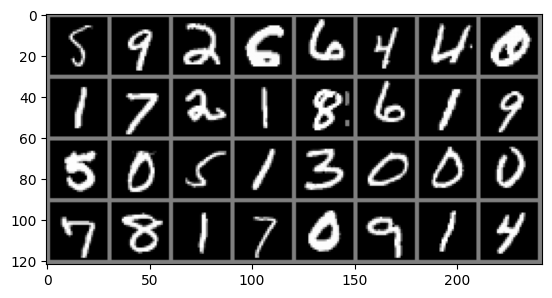

In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j].item() for j in range(batch_size)))

Generator

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 6272),  # Equivalent to Dense(77128)
            nn.LeakyReLU(0.2),  # LeakyReLU(0.2)
            nn.Unflatten(1, (128, 7, 7)),  # Equivalent to Reshape([7, 7, 128])
            nn.Upsample(scale_factor=2),  # UpSampling2D(size=(2, 2))
            nn.Conv2d(128, 64, kernel_size=5, padding='same'),  # Conv2D(64, (5, 5), padding='same')
            nn.LeakyReLU(0.2),  # LeakyReLU(0.2)
            nn.Upsample(scale_factor=2),  # UpSampling2D(size=(2, 2))
            nn.Conv2d(64, 1, kernel_size=5, padding='same'),  # Conv2D(1, (5, 5), padding='same')
            nn.Tanh()  # Activation('tanh')
        )

    def forward(self, x):
        return self.model(x)

# Create the generator and print its summary
G = Generator().cuda()
from torchsummary import summary
summary(G, (100, ), batch_size=-1, device='cuda')
print("_____________________ Generator Created_____________________")

    5     9     2     6     6     4     4     0     1     7     2     1     8     6     1     9     5     0     5     1     3     0     0     0     7     8     1     7     0     9     1     4
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 6272]         633,472
         LeakyReLU-2                 [-1, 6272]               0
         Unflatten-3            [-1, 128, 7, 7]               0
          Upsample-4          [-1, 128, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]         204,864
         LeakyReLU-6           [-1, 64, 14, 14]               0
          Upsample-7           [-1, 64, 28, 28]               0
            Conv2d-8            [-1, 1, 28, 28]           1,601
              Tanh-9            [-1, 1, 28, 28]               0
Total params: 839,937
Trainable params: 839,937
Non-trainable params: 0
-------------------------------

Discriminator

Khai báo mạng discriminator

    + Đầu vào là một ảnh 28x28
    + Đầu ra là một xác suất cho ta biết ảnh đấy là real hay fake với giá trị trong miền [0, 1]

Thông số của mạng như sau:

-  Conv2D(64, (5, 5), strides=(2, 2), padding= 'same',input_shape=shp)
-  LeakyReLU(0.2)
-  Dropout(dropout_rate)
-  Conv2D(128, (5, 5), strides=(2, 2), padding = 'same')
-  LeakyReLU(0.2)
-  Dropout(dropout_rate)
-  Flatten()
-  Dense(1,activation='sigmoid')

In [6]:
class Discriminator(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # First Conv Layer
            nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),

            # Second Conv Layer
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),

            # Flatten
            nn.Flatten(),

            # Dense layer
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

D = Discriminator().cuda()
summary(D, (1, 28, 28), batch_size=-1, device='cuda')
print("____________________ Discriminator Created____________________")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           1,664
         LeakyReLU-2           [-1, 64, 14, 14]               0
           Dropout-3           [-1, 64, 14, 14]               0
            Conv2d-4            [-1, 128, 7, 7]         204,928
         LeakyReLU-5            [-1, 128, 7, 7]               0
           Dropout-6            [-1, 128, 7, 7]               0
           Flatten-7                 [-1, 6272]               0
            Linear-8                    [-1, 1]           6,273
           Sigmoid-9                    [-1, 1]               0
Total params: 212,865
Trainable params: 212,865
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.48
Params size (MB): 0.81
Estimated Total Size (MB): 1.29
-------------------------------------------

GANs Model

In [7]:
def gans(G, D, z):
  fake = G(z)
  predictions = D(fake)

  return predictions, fake


lr = 0.0002
betas = (0.5, 0.999)
optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=betas)
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=betas)

criterion = nn.BCELoss()

epochs = 100
batch_size = 64

losses_G = []
losses_D = []
samples = []

In [8]:
for epoch in range(epochs):
    for (i, (imgs, _)) in enumerate(trainloader, start=1):
        # Adversarial ground truths
        valid = Variable(torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake_labels = Variable(torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(torch.cuda.FloatTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise
        z = Variable(torch.cuda.FloatTensor(np.random.normal(0, 1, (imgs.shape[0], 100))))

        pred_fake, gen_imgs = gans(G, D, z)

        g_loss = criterion(pred_fake, valid)
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        real_loss = criterion(D(real_imgs), valid)

        # Discriminator
        fake_loss = criterion(D(gen_imgs.detach()), fake_labels)

        # Total discriminator loss
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        if epoch % 10 == 0 and i == len(trainloader):
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, epochs, i, len(trainloader), d_loss.item(), g_loss.item())
            )

            losses_G.append(g_loss.item())
            losses_D.append(d_loss.item())
            samples.append(gen_imgs)

<ipython-input-8-fb573c31e38f>:4: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:78.)
  valid = Variable(torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)


[Epoch 0/100] [Batch 1875/1875] [D loss: 0.000010] [G loss: 10.907188]
[Epoch 10/100] [Batch 1875/1875] [D loss: 0.000000] [G loss: 17.839920]
[Epoch 20/100] [Batch 1875/1875] [D loss: 0.000000] [G loss: 23.872501]
[Epoch 30/100] [Batch 1875/1875] [D loss: 50.000000] [G loss: 0.000000]
[Epoch 40/100] [Batch 1875/1875] [D loss: 50.000000] [G loss: 0.000000]
[Epoch 50/100] [Batch 1875/1875] [D loss: 50.000000] [G loss: 0.000000]
[Epoch 60/100] [Batch 1875/1875] [D loss: 50.000000] [G loss: 0.000000]
[Epoch 70/100] [Batch 1875/1875] [D loss: 50.000000] [G loss: 0.000000]
[Epoch 80/100] [Batch 1875/1875] [D loss: 50.000000] [G loss: 0.000000]
[Epoch 90/100] [Batch 1875/1875] [D loss: 50.000000] [G loss: 0.000000]


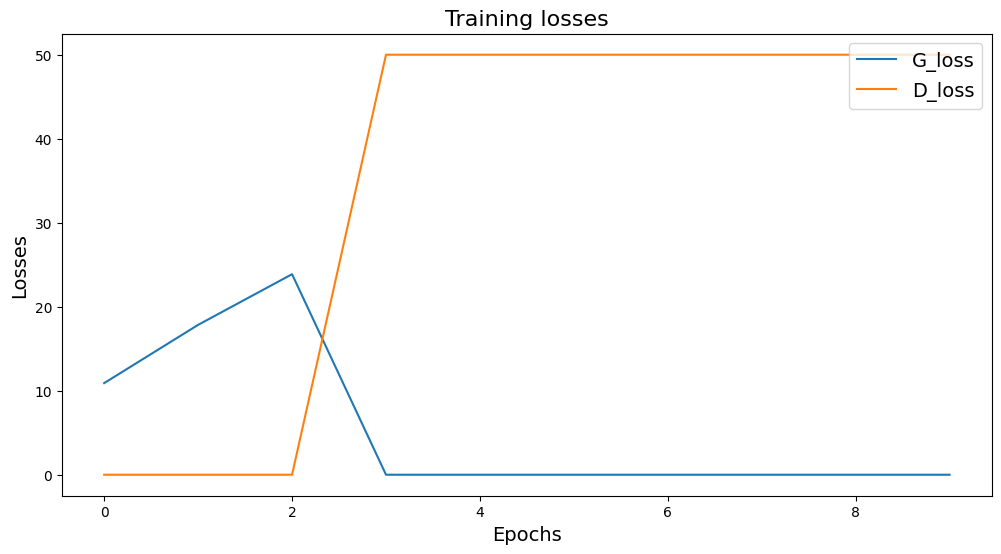

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(list(range(len(losses_G)//10*10)), losses_G, label="G_loss")
plt.plot(list(range(len(losses_D)//10*10)), losses_D, label="D_loss")
plt.title("Training losses", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Losses", fontsize=14)
plt.legend(loc="upper right", fontsize=14)
plt.show()